In [ ]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json

# === Загрузка данных ===
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Параметры ===
NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

# === Фитнес-функция ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    penalty = 0.0
    absolute_arrival = ind[3]  

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации ===
def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)
    return best

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay

if __name__ == "__main__":
    best_solution = run()
    bus_only_delay = compute_bus_delay(best_solution)
    print(f"🚌 Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")


gen	nevals	min   	avg   
0  	300   	371653	772429
1  	237   	371653	6.60224e+08
2  	242   	453023	7.30181e+08
3  	219   	453023	7.06863e+08
4  	229   	491240	7.20194e+08
5  	250   	491240	7.03545e+08
6  	226   	491240	6.53589e+08
7  	232   	491240	6.03626e+08
8  	226   	472498	5.3367e+08 
9  	227   	472498	5.40327e+08
10 	231   	464524	5.33659e+08
11 	232   	464524	5.13659e+08
12 	234   	472498	5.33641e+08
13 	232   	462362	4.90327e+08
14 	240   	462362	5.23634e+08
15 	244   	423169	4.9365e+08 
16 	244   	423169	4.47011e+08
17 	224   	423169	4.13687e+08
18 	229   	430343	4.20341e+08
19 	225   	430343	4.07008e+08
20 	237   	414282	4.13663e+08
21 	241   	400683	4.26978e+08
22 	216   	400683	4.03651e+08
23 	228   	400683	3.90315e+08
24 	230   	400683	3.73651e+08
25 	245   	399134	4.26955e+08
26 	227   	379056	3.96964e+08
27 	216   	379056	3.60314e+08
28 	235   	367572	4.13616e+08
29 	238   	379056	4.43599e+08
30 	224   	379056	4.2694e+08 
31 	249   	367510	4.93572e+08
32 	241   	367510	4.

In [2]:
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации
plan_after = {
    i + 1: {
        "cycle": best[i * GENE_SIZE],
        "main": best[i * GENE_SIZE + 1],
        "sec": best[i * GENE_SIZE + 2]
    } for i in range(NUM_INTERSECTIONS)
}

# Функция расчёта среднего времени ожидания пешеходов
def pedestrian_wait_time(plan):
    total_wait = 0
    for node in plan:
        cycle = plan[node]["cycle"]
        ped_green = min(plan[node]["main"], plan[node]["sec"])  # предположение
        wait = cycle - ped_green
        total_wait += wait
    return total_wait / len(plan)

# Расчёты и вывод
wait_before = pedestrian_wait_time(plan_before)
wait_after = pedestrian_wait_time(plan_after)

print(f"🚶 Среднее ожидание пешеходов ДО оптимизации: {wait_before:.2f} сек")
print(f"🚦 Среднее ожидание пешеходов ПОСЛЕ оптимизации: {wait_after:.2f} сек")

🚶 Среднее ожидание пешеходов ДО оптимизации: 100.00 сек
🚦 Среднее ожидание пешеходов ПОСЛЕ оптимизации: 55.01 сек


In [ ]:
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
flows_df = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Построение плана ДО оптимизации ===
signal_plan_before = {}
for _, row in signals_df.iterrows():
    inter_id = int(row["intersection_id"])
    signal_plan_before[inter_id] = {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"],
        "offset": 0,
        "abs_offset": 0
    }

# === Подсчёт задержки ===
def compute_total_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share
            total += (cycle - eff_green) * flow * weight
    return total

def compute_bus_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            total += (cycle - eff_green) * flow_bus
    return total

# === Выполнение расчёта ===
total_delay_before = compute_total_delay(signal_plan_before, flows_df, constraints)
bus_delay_before = compute_bus_delay(signal_plan_before, flows_df, constraints)

print(f"📊 Общая задержка ДО оптимизации: {total_delay_before:,.2f} машино-сек")
print(f"🚌 Задержка по автобусам ДО оптимизации: {bus_delay_before:,.2f} машино-сек")

📊 Общая задержка ДО оптимизации: 778,557.00 машино-сек
🚌 Задержка по автобусам ДО оптимизации: 44,028.50 машино-сек


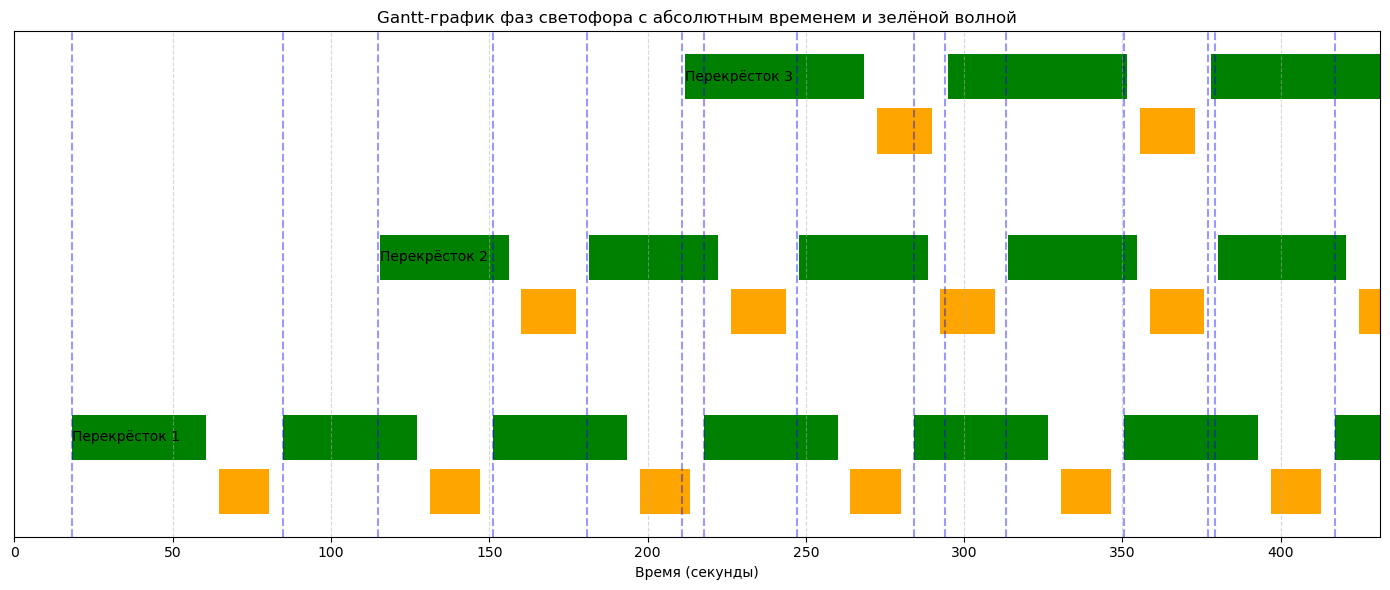

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации с abs_offset
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    cycle = best[i * GENE_SIZE]
    main = best[i * GENE_SIZE + 1]
    sec = best[i * GENE_SIZE + 2]
    # Если offset есть как параметр в solution:
    offset = best[i * GENE_SIZE + 3]
    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": cycle,
        "main": main,
        "sec": sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += cycle

# Параметры
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2  # время отображения

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}
TRAVEL_TIME = 30
# Вычисляем накопленное время (сумму циклов) для каждого перекрёстка
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += plan_after[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Рисуем несколько циклов главной фазы подряд
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Аналогично второстепенная фаза (начинается после main + lost_time)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    # Рисуем линии прибытия транспорта (зелёная волна) для нескольких циклов
    # Рисуем линии прибытия транспорта (зелёная волна) для нескольких циклов
    for k in range(int(plot_duration // cycle) + 1):
        arrival = plan_after[1]['abs_offset'] + TRAVEL_TIME * (inter_id - 1) + k * cycle + time_accums[i - 1]
        ax.axvline(arrival, color='blue', linestyle='--', alpha=0.4)


    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора с абсолютным временем и зелёной волной")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	377071	757990
1  	249   	377071	6.93538e+08
2  	246   	377071	7.30184e+08
3  	224   	440352	6.96877e+08
4  	238   	465869	7.00206e+08
5  	236   	465869	7.06866e+08
6  	243   	485588	7.00199e+08
7  	239   	469582	6.50237e+08
8  	237   	483797	6.03605e+08
9  	247   	506791	5.86952e+08
10 	222   	469072	4.73696e+08
11 	235   	471293	4.83678e+08
12 	233   	460300	4.17043e+08
13 	237   	478859	4.03708e+08
14 	223   	477230	3.83711e+08
15 	232   	454149	3.70369e+08
16 	238   	457565	4.33654e+08
17 	257   	422507	4.86953e+08
18 	236   	402733	3.97e+08   
19 	226   	417317	3.63682e+08
20 	242   	441384	4.33642e+08
21 	243   	437434	3.90329e+08
22 	244   	439436	3.8033e+08 
23 	242   	423362	3.7366e+08 
24 	235   	419169	3.86981e+08
25 	238   	419169	3.86976e+08
26 	238   	401889	3.63649e+08
27 	241   	401889	4.46935e+08
28 	225   	361896	4.0362e+08 
29 	239   	361896	3.43641e+08
30 	244   	361896	3.46967e+08
31 	237   	361896	4.06937e+08
32 	236   	361896	4.

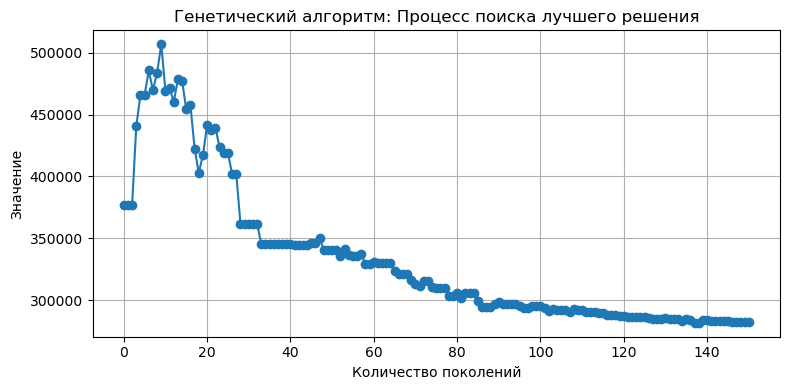

In [7]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json
import matplotlib.pyplot as plt

# === Загрузка данных ===
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Параметры ===
NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

# === Фитнес-функция ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # Проверка ограничений
        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        # Задержка по всем потокам с приоритетом автобусов
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    # Координация (зелёная волна) с умеренным штрафом
    penalty = 0.0
    absolute_arrival = ind[3]  # offset первого перекрёстка

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации с логированием ===
def run_with_stats():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    _, logbook = algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)

    return logbook

# === Вызов оптимизации и построение графика ===
logbook = run_with_stats()

gens = logbook.select("gen")       # список поколений [0, 1, 2, …]
best_vals = logbook.select("min")  # лучшая (минимальная) ценность фитнеса на каждом поколении

plt.figure(figsize=(8, 4))
plt.plot(gens, best_vals, marker="o", linestyle="-")
plt.title("Генетический алгоритм: Процесс поиска лучшего решения")
plt.xlabel("Количество поколений")
plt.ylabel("Значение")
plt.grid(True)
plt.tight_layout()
plt.show()


### Обновленная фитнес функция с гостами

In [8]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json

# === Загрузка данных ===
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

In [9]:
# === ГОСТОВЫЕ "захардкоженные" параметры ===
TYPICAL_LANES_MAIN = 2  # Главная дорога: 2 полосы
TYPICAL_LANES_SEC = 1   # Второстепенная: 1 полоса
LANE_WIDTH = 3.5        # м
ROAD_WIDTH_MAIN = TYPICAL_LANES_MAIN * LANE_WIDTH
ROAD_WIDTH_SEC = TYPICAL_LANES_SEC * LANE_WIDTH
PEDESTRIAN_SPEED = 1.3  # м/с (ГОСТ)
LOST_TIME = constraints['lost_time_sec_per_phase']  # Уже есть в данных
MIN_CYCLE = constraints['min_cycle_sec']
MAX_CYCLE = constraints['max_cycle_sec']
MIN_GREEN = constraints['min_green_sec']

# Время для пешехода (по главной и второстепенной)
PEDESTRIAN_GREEN_MAIN = 5 + ROAD_WIDTH_MAIN / PEDESTRIAN_SPEED   # ~10.4 сек
PEDESTRIAN_GREEN_SEC = 5 + ROAD_WIDTH_SEC / PEDESTRIAN_SPEED     # ~7.7 сек

NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

In [ ]:
# === Фитнес-функция с ГОСТ-проверками ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * LOST_TIME

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # 1. Проверка по ГОСТ: цикл
        if not (MIN_CYCLE <= cycle <= MAX_CYCLE):
            return (1e9,)
        # 2. Минимальные фазы для транспорта
        if g_main < MIN_GREEN or g_sec < MIN_GREEN:
            return (1e9,)
        # 3. Минимальная длительность пешеходной фазы по ГОСТ (типовая геометрия!)
        if g_main < PEDESTRIAN_GREEN_MAIN or g_sec < PEDESTRIAN_GREEN_SEC:
            return (1e9,)
        # 4. Сумма фаз и потерь не превышает цикл
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        # 5. Смещение offset в допустимых границах
        if not (0 <= offset <= cycle):
            return (1e9,)

        # === Считаем задержку потоков ===
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share  # приоритет для автобусов

            total_delay += (cycle - eff_green) * flow * weight

    # === Штраф за рассинхронизацию "зелёной волны" ===
    penalty = 0.0
    absolute_arrival = ind[3]  # offset первого перекрёстка

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * LOST_TIME
    for idx in range(NUM_INTERSECTIONS):
        c = random.randint(MIN_CYCLE, MAX_CYCLE)
        while True:
            g1 = random.randint(MIN_GREEN, c - MIN_GREEN - lost)
            g2 = random.randint(MIN_GREEN, c - MIN_GREEN - lost)
            # Учитываем пешеходные ГОСТ-ограничения!
            if (g1 >= PEDESTRIAN_GREEN_MAIN and g2 >= PEDESTRIAN_GREEN_SEC and g1 + g2 + lost <= c):
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации ===
def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)
    return best

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay

if __name__ == "__main__":
    best_solution = run()
    bus_only_delay = compute_bus_delay(best_solution)
    print(f"🚌 Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")


c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	401891	760527
1  	242   	424767	6.8354e+08
2  	237   	424767	7.10195e+08
3  	227   	395845	7.36844e+08
4  	214   	395845	7.03536e+08
5  	233   	470242	7.23524e+08
6  	227   	470242	7.26856e+08
7  	219   	460199	6.93539e+08
8  	228   	466946	6.76876e+08
9  	225   	442383	6.13591e+08
10 	239   	441334	6.03601e+08
11 	240   	441334	5.13656e+08
12 	230   	495860	4.87001e+08
13 	242   	478477	4.67007e+08
14 	252   	454894	4.40358e+08
15 	227   	452460	4.10353e+08
16 	237   	419415	4.56982e+08
17 	241   	406112	4.43647e+08
18 	248   	406112	4.07001e+08
19 	227   	406112	4.20315e+08
20 	232   	406112	4.03652e+08
21 	231   	424227	3.47012e+08
22 	241   	417772	3.86978e+08
23 	232   	415554	3.83642e+08
24 	239   	398709	3.73644e+08
25 	240   	395057	3.10337e+08
26 	241   	381131	3.43649e+08
27 	232   	381131	3.70299e+08
28 	236   	381131	4.00283e+08
29 	243   	381131	4.33597e+08
30 	249   	381131	3.66961e+08
31 	257   	355011	4.36923e+08
32 	236   	355011	3.8

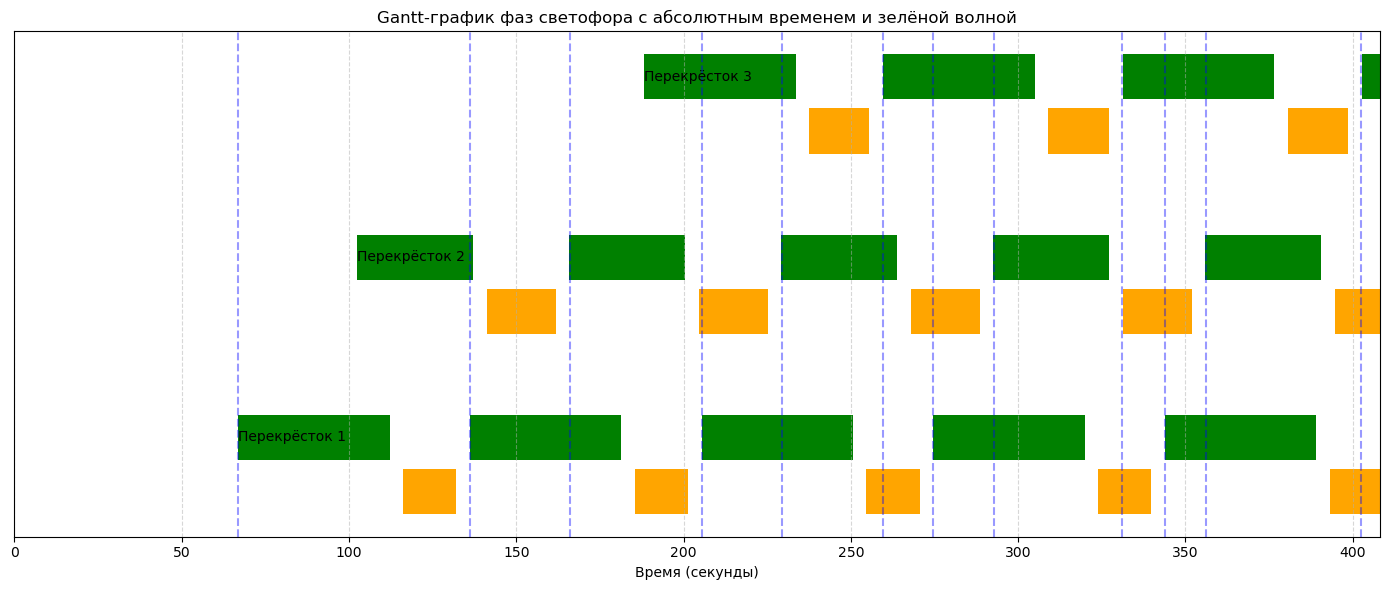

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации (если нужно для сравнения)
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации с abs_offset
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    cycle = best[i * GENE_SIZE]
    main = best[i * GENE_SIZE + 1]
    sec = best[i * GENE_SIZE + 2]
    offset = best[i * GENE_SIZE + 3]
    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": cycle,
        "main": main,
        "sec": sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += cycle

# === ВИЗУАЛИЗАЦИЯ ===
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2  # сколько секунд рисовать

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}
TRAVEL_TIME = 30

# Накопленные циклы — для расчёта абсолютного прибытия (green wave)
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += plan_after[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    # Линии прибытия транспорта (зелёная волна)
    for k in range(int(plot_duration // cycle) + 1):
        arrival = plan_after[1]['abs_offset'] + TRAVEL_TIME * (inter_id - 1) + k * cycle + time_accums[i - 1]
        ax.axvline(arrival, color='blue', linestyle='--', alpha=0.4)

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора с абсолютным временем и зелёной волной")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Генетический алгоритм без зеленой волны

In [16]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json

# === Загрузка данных ===
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Параметры ===
NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

# === Фитнес-функция ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    # *** Без штрафа за зелёную волну ***
    return (total_delay, )

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации ===
def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)
    return best

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay

if __name__ == "__main__":
    best_solution = run()
    bus_only_delay = compute_bus_delay(best_solution)
    print(f"🚌 Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")


c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	344776	725442
1  	241   	344776	6.80198e+08
2  	252   	387409	7.7681e+08 
3  	249   	414445	7.83475e+08
4  	248   	406088	7.80147e+08
5  	244   	478562	7.33509e+08
6  	245   	462835	7.20181e+08
7  	230   	462479	6.53556e+08
8  	244   	459971	5.43616e+08
9  	239   	430644	4.80316e+08
10 	235   	430644	4.03696e+08
11 	242   	405195	4.07004e+08
12 	243   	405195	3.90334e+08
13 	239   	372899	4.1031e+08 
14 	236   	390553	4.16964e+08
15 	245   	361855	4.03632e+08
16 	223   	378139	3.83634e+08
17 	242   	355665	4.40265e+08
18 	221   	355665	3.93616e+08
19 	246   	355665	4.66907e+08
20 	242   	355665	4.20257e+08
21 	225   	352041	4.30246e+08
22 	248   	357287	4.10253e+08
23 	238   	358884	3.86927e+08
24 	238   	350929	4.36904e+08
25 	245   	350929	3.56936e+08
26 	234   	347030	3.536e+08  
27 	234   	344891	3.1028e+08 
28 	245   	332174	3.7358e+08 
29 	207   	322572	2.90273e+08
30 	243   	342800	3.66909e+08
31 	224   	330219	3.60241e+08
32 	238   	317442	4.

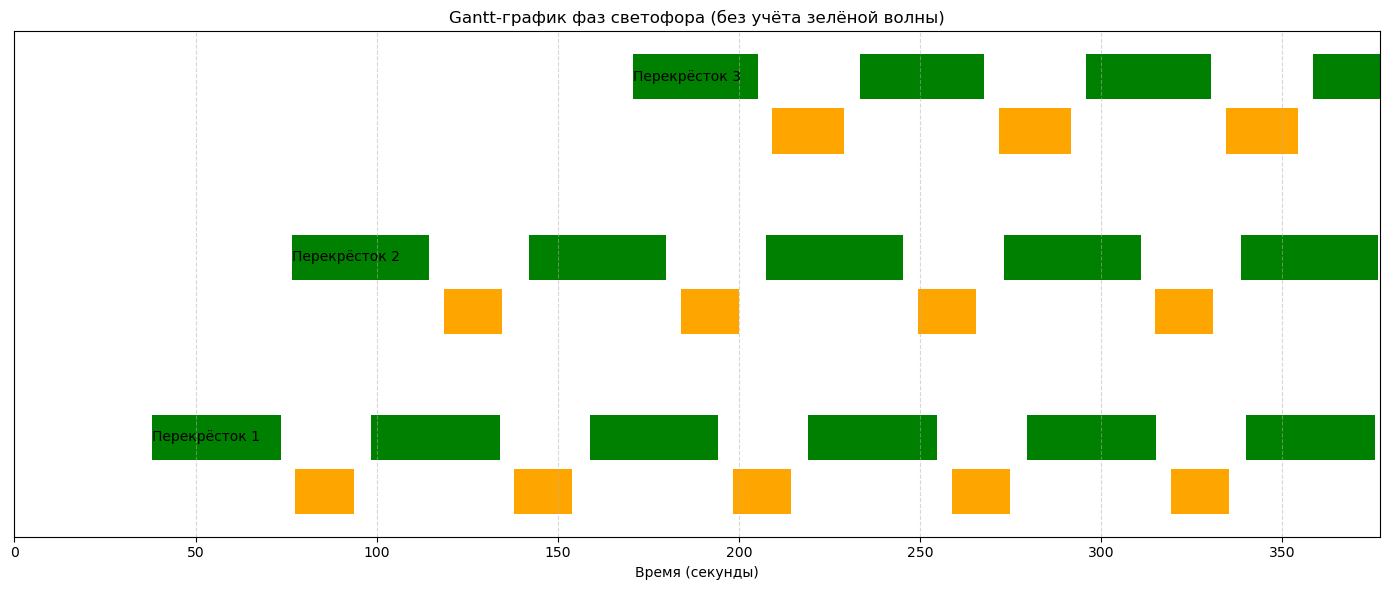

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации с abs_offset
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    cycle = best[i * GENE_SIZE]
    main = best[i * GENE_SIZE + 1]
    sec = best[i * GENE_SIZE + 2]
    # Если offset есть как параметр в solution:
    offset = best[i * GENE_SIZE + 3]
    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": cycle,
        "main": main,
        "sec": sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += cycle

# Параметры
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2  # время отображения

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}
TRAVEL_TIME = 30
# Вычисляем накопленное время (сумму циклов) для каждого перекрёстка
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += plan_after[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

# Всё остальное как есть:
ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора (без учёта зелёной волны)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
